In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt

In [4]:
!wget "https://botxfiles.herokuapp.com/5786355977748416/2020%20JAN%20NIFTY.txt"

--2020-09-25 19:05:06--  https://botxfiles.herokuapp.com/5786355977748416/2020%20JAN%20NIFTY.txt
Resolving botxfiles.herokuapp.com (botxfiles.herokuapp.com)... 34.249.148.135, 54.76.8.179, 54.77.221.101, ...
Connecting to botxfiles.herokuapp.com (botxfiles.herokuapp.com)|34.249.148.135|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 540516 (528K) [text/plain]
Saving to: ‘2020 JAN NIFTY.txt’

2020 JAN NIFTY.txt  100%[===================>] 527.85K   968KB/s    in 0.5s    

2020-09-25 19:05:07 (968 KB/s) - ‘2020 JAN NIFTY.txt’ saved [540516/540516]



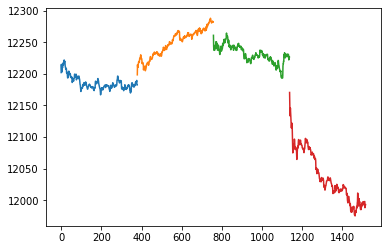

In [5]:
df=pd.read_csv('2020 JAN NIFTY.txt',header=None)
df.drop(labels=[0,7,8],axis=1,inplace=True)
d=379
df.columns=['date','time','open','high','low','close']
plt.plot(range(379),df.close[:379])
plt.plot(range(379,758),df.close[379:758])
plt.plot(range(2*d,3*d),df.close[2*d:3*d])
plt.plot(range(3*d,4*d),df.close[3*d:4*d])
dff=df['close']

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
series=dff
split_time = 303
x_train = dff[:split_time]
x_valid = dff[split_time:379]
tf.random.set_seed(51)
np.random.seed(51)
x_valid=x_valid.values.reshape(-1,1)
x_train=x_train.values.reshape(-1,1)
series=series.values.reshape(-1,1)
scaler=preprocessing.MinMaxScaler()
x_train=scaler.fit_transform(x_train)
x_valid=scaler.transform(x_valid)
series=scaler.transform(series)
x_valid=x_valid.reshape(-1)
x_train=x_train.reshape(-1)
series=series.reshape(-1)
window_size = 15
batch_size=30
shuffle_buffer=20
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer)

In [8]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(128, return_sequences=True),
  tf.keras.layers.LSTM(512, return_sequences=True),

  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(10),
  tf.keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
10/10 [==============================] - 0s 13ms/step - loss: 0.4748 - mae: 0.8292
Epoch 2/100
10/10 [==============================] - 0s 9ms/step - loss: 0.4706 - mae: 0.8234
Epoch 3/100
10/10 [==============================] - 0s 9ms/step - loss: 0.4641 - mae: 0.8148
Epoch 4/100
10/10 [==============================] - 0s 8ms/step - loss: 0.4565 - mae: 0.8044
Epoch 5/100
10/10 [==============================] - 0s 8ms/step - loss: 0.4479 - mae: 0.7927
Epoch 6/100
10/10 [==============================] - 0s 9ms/step - loss: 0.4385 - mae: 0.7796
Epoch 7/100
10/10 [==============================] - 0s 9ms/step - loss: 0.4281 - mae: 0.7651
Epoch 8/100
10/10 [==============================] - 0s 9ms/step - loss: 0.4169 - mae: 0.7492
Epoch 9/100
10/10 [==============================] - 0s 9ms/step - loss: 0.4048 - mae: 0.7318
Epoch 10/100
10/10 [==============================] - 0s 8ms/step - loss: 0.3918 - mae: 0.7128
Epoch 11/100
10/10 [==============================] - 0s 8

(1e-08, 0.0001, 0.0, 30.0)

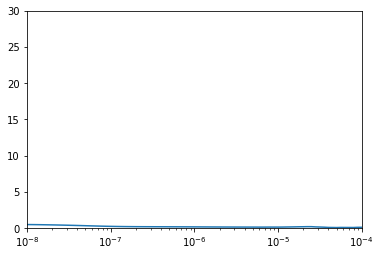

In [9]:
plt.semilogx(history.history["lr"], history.history["loss"])

plt.axis([1e-8, 1e-4, 0, 30])


In [40]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation=None,
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(128, return_sequences=True),
  tf.keras.layers.LSTM(512, return_sequences=True),

  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(10),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.Adam(lr=1e-4)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=60)

Epoch 1/60
288/288 [==============================] - 2s 6ms/step - loss: 0.0372 - mae: 0.1405
Epoch 2/60
288/288 [==============================] - 2s 6ms/step - loss: 0.0109 - mae: 0.0940
Epoch 3/60
288/288 [==============================] - 2s 7ms/step - loss: 0.0064 - mae: 0.0794
Epoch 4/60
288/288 [==============================] - 2s 7ms/step - loss: 0.0084 - mae: 0.0895
Epoch 5/60
288/288 [==============================] - 2s 7ms/step - loss: 0.0077 - mae: 0.0835
Epoch 6/60
288/288 [==============================] - 2s 7ms/step - loss: 0.0050 - mae: 0.0711
Epoch 7/60
288/288 [==============================] - 2s 7ms/step - loss: 0.0052 - mae: 0.0714
Epoch 8/60
288/288 [==============================] - 2s 7ms/step - loss: 0.0045 - mae: 0.0691
Epoch 9/60
288/288 [==============================] - 2s 6ms/step - loss: 0.0044 - mae: 0.0661
Epoch 10/60
288/288 [==============================] - 2s 7ms/step - loss: 0.0041 - mae: 0.0646
Epoch 11/60
288/288 [============================

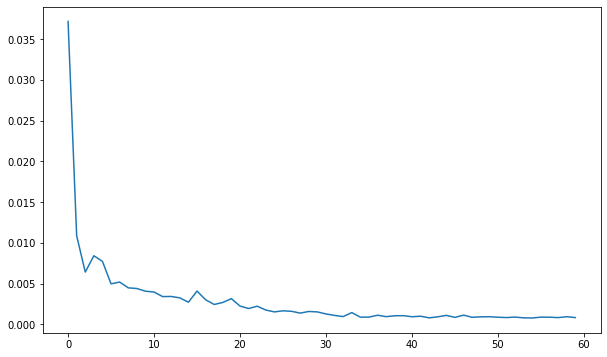

In [41]:
plt.figure(figsize=(10,6))
plt.plot(range(len(history.history["loss"])), history.history["loss"])


In [42]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:379-window_size, -1, 0]

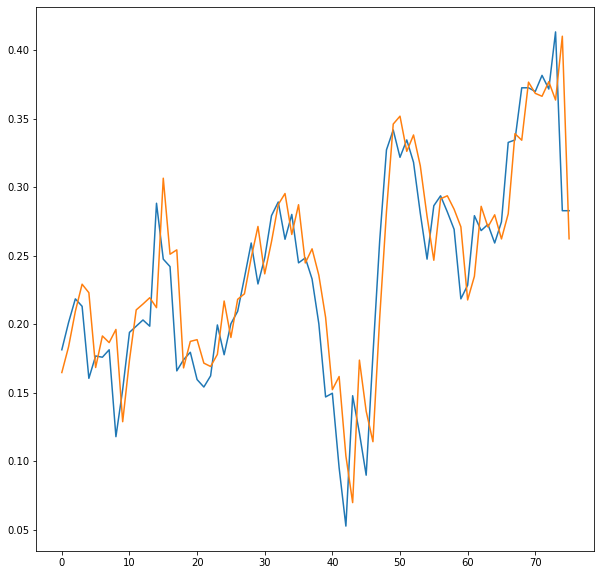

In [43]:

plt.figure(figsize=(10, 10))

plt.plot(range(len(x_valid)), x_valid)
plt.plot(range(len(rnn_forecast)), rnn_forecast)


In [44]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

0.028203964

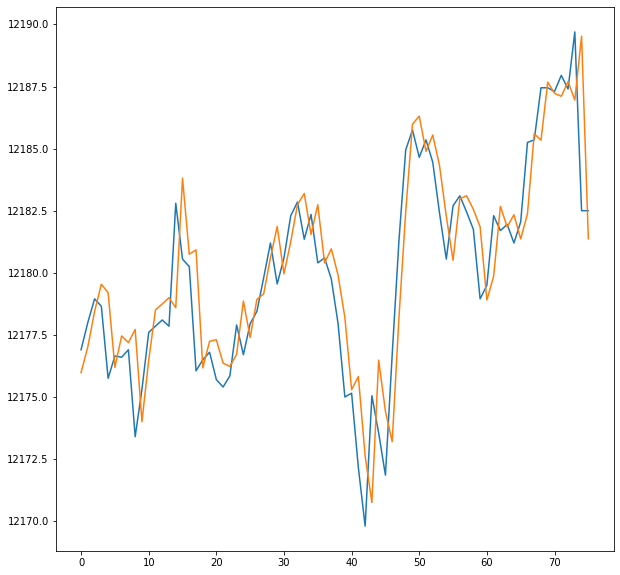

In [45]:
x_valid=x_valid.reshape(-1,1)
x_valid=scaler.inverse_transform(x_valid)
rnn_forecast=rnn_forecast.reshape(-1,1)
rnn_forecast=scaler.inverse_transform(rnn_forecast)
plt.figure(figsize=(10, 10))

plt.plot(range(len(x_valid)), x_valid)
plt.plot(range(len(rnn_forecast)), rnn_forecast)


In [46]:
print(tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy().mean())


1.5553942
